In [6]:
"""
Author : Romain BAHARIAN, Dalyl MOUHAMMADI, Lola MURGATROYD, Dilan GAJASINGHE
Date : 14/03/2025 - 08/04/2025
Windows 11, VSCode, python 3.12.3

"""

if __name__ == '__main__': 
    from multiprocessing import freeze_support                                  # Pour éviter les erreurs de multiprocessing sous Windows
    freeze_support() 

# Section des importations

    import os                                                                   # Pour les opérations système
    import torch                                                                # Pour le calcul numérique 
    import warnings                                                             # Pour les avertissements
    import rasterio                                                             # Pour les images
    import numpy as np                                                          # Pour les calculs numériques	
    import torchvision                                                          # Pour les modèles
    import itertools                                                            # Pour les itérations
    from math import *                                                          # Pour les fonctions mathématiques
    import pandas as pd                                                         # Pour les dataframes
    import seaborn as sns                                                       # Pour les graphiques
    from tqdm import tqdm                                                       # Pour les barres de progression
    import torch.nn as nn                                                       # Pour les réseaux de neurones   
    import torch.optim as optim                                                 # Pour les optimiseurs                            
    import matplotlib.pyplot as plt                                             # Pour les graphiques
    from eoreader.reader import Reader                                          # Pour lire les images
    from skimage import filters, color                                          # Pour les filtres
    from PIL import ImageEnhance, Image                                         # Pour les images
    from torchvision.models import resnet18, efficientnet_b0                    # Pour les modèles
    from torchvision.utils import make_grid                                     # Pour afficher les images
    import torchvision.transforms as transforms                                 # Pour les transformations
    from torchvision import datasets, transforms, models                        # Pour les modèles
    from torchvision.transforms.functional import to_pil_image                  # Pour convertir un tensor en image
    from sklearn.metrics import confusion_matrix, accuracy_score                # Pour les métriques    
    from torch.utils.data import DataLoader, Dataset, random_split              # Pour charger les données
    from eoreader.bands import RED, GREEN, NDVI, YELLOW, CLOUDS, to_str         # Pour les bandes

    from custom_dataset import SubclassImageFolder  # Importer la classe custom SubclassImageFolder pour travailler avec les sous-classes


    #Function to choose the device : CPU, GPU or Apple Metal
    def get_device():
        if torch.cuda.is_available():
            #Use CUDA device if available
            return torch.device("cuda"), "GPU"
        elif torch.backends.mps.is_available():
            #Use Apple Metal if available on Mac
            return torch.device("cuda"), "Apple Metal"
        else:
            # default to CPU
            return torch.device("cuda"), "CPU"

    #Setting the device
    device, device_name = get_device()
    print(f"Using device: {device_name}")


    """
    =========================================================================================================================
    =========================================================================================================================
                                PARTIE 1 - PRETRAITEMENT & AFFICHAGE DES CLASSES ET SOUS-CLASSES
    =========================================================================================================================
    =========================================================================================================================
    """
    
        # Transformation sequence to resize, crop, convert to tensor, and normalize the images
    transform = transforms.Compose([
        transforms.Resize(256),  #Resize each image to 256x256 pixels
        transforms.CenterCrop(224),  #Crop the central 224x224 area
        transforms.ToTensor(),  #Convert image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalize tensor data
    ])

    #Load images from structured directory with automatic labeling based on folder names and apply transformations
    data_directory = '.\\RSI-CB128' # Récupération du dossier par le dossier courant (d'ou le .\\)
    dataset = datasets.ImageFolder(root=data_directory, transform=transform)


    """
    -------------------------- Création du dictionnaire pour stocker les classes et sous-classes --------------------------
    -----------------------------------------------------------------------------------------------------------------------
    """

    # Initialisation du dictionnaire pour stocker les classes et sous-classes
    class_hierarchy = {}

    # Parcours des fichiers du dataset
    for path, index in dataset.samples:  # dataset.samples contient (chemin, index de classe)      
        relative_path = os.path.relpath(path, data_directory) # Extraire le chemin relatif par rapport au dossier racine

        # Découper les dossiers pour identifier classe principale et sous-classe
        parts = relative_path.split(os.sep)  # Séparation selon "/"
        if len(parts) < 2:
            continue  # Ignorer les fichiers mal placés

        class_principale, sous_classe = parts[0], parts[1]  # Ex: ('animaux', 'chat')

        # Initialiser la classe principale si elle n'existe pas
        if class_principale not in class_hierarchy:
            class_hierarchy[class_principale] = {}

        # Ajouter la sous-classe et compter les images
        if sous_classe in class_hierarchy[class_principale]:
            class_hierarchy[class_principale][sous_classe] += 1
        else:
            class_hierarchy[class_principale][sous_classe] = 1

    """
    --------------------------------- Fin de la création du dictionnaire : affichage --------------------------------
    -----------------------------------------------------------------------------------------------------------------
    """

    # Affichage de l'organisation des classes et sous-classes
    print("\nOrganisation des classes et sous-classes :")
    for class_principale, sous_classes in class_hierarchy.items():
        print(f"\nClasse principale : {class_principale}")
        for sous_classe, count in sous_classes.items():
            print(f"  - {sous_classe}: {count} images")

    # Calcul total d'images
    total_images = sum(sum(sous_classes.values()) for sous_classes in class_hierarchy.values())
    print(f"\nTotal d'images dans le dataset : {total_images}")


    """
    ==========================================================================================================
    ==========================================================================================================
                                          PARTIE 2 - ENTRAINEMENT DU MODÈLE
    ==========================================================================================================
    ==========================================================================================================
    """

    #DataLoader manages data shuffling and batching automatically
    batch_size = 32  #Defines how many samples are processed before the model updates
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    images, _ = next(iter(data_loader)) 

    #Display the number of images
    print("\n------ RECAP DATA IMAGES ------")
    print(f'Total images: {len(dataset)}')
    print(f'Size of image: {images.shape}') # Vérification de la taille des images
    print("\n")

    """
    --------------------------------- Affichage de 6 images prétraitées --------------------------------
    ----------------------------------------------------------------------------------------------------
    """

    def show_six_images(data_loader, dataset):
        # Fetch the first batch of images and labels
        images, classes = next(iter(data_loader))

        # Define the number of images to display
        num_images = 6

        # Create a figure with subplots in a 2x3 configuration
        fig, axes = plt.subplots(2, 3, figsize=(10, 10))  # 2 rows, 3 columns
        axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

        # Loop through the first six images (or less if the batch is smaller)
        for idx, ax in enumerate(axes):
            if idx < num_images:
                # Convert the tensor image to a NumPy array for display
                img = images[idx].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

                # Display the image
                ax.imshow(img)
                ax.set_title(f'Class: {dataset.classes[classes[idx]]}')  # Set the title to the class label
                ax.axis('off')  # Hide the axes
            else:
                ax.axis('off')  # Hide unused subplots

        plt.tight_layout()
        plt.show()

   # show_six_images(data_loader,dataset)   # Afficher 6 images prétraitées du dataset



    """
    -------------------------------------- Transformation pour modèle -------------------------------------
    -------------------------------------------------------------------------------------------------------
    """

        #Transformations for the training data (with augmentation)
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  #Convert 1 channel grayscale (MNIST) to 3 channel for model ResNet-18 input
        transforms.RandomRotation(10, fill=(0,0,0)),  #Rotate by up to 10 degrees filling with 0
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  #Random translation
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
    ])

    #Transformations for the testing data (without augmentation)
    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  #Convert 1 channel grayscale (MNIST) to 3 channel for model ResNet-18 input
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
    ])

    """
    ------ Chargement du dataset pour l'entrainement et le test, affichage des classes et sous-classes ---------
    ------------------------------------------------------------------------------------------------------------
    """

    # Loading dataset traditional way (superclasses only) 
    #train_dataset = datasets.ImageFolder(root=data_directory, transform=train_transform)
    #test_dataset = datasets.ImageFolder(root=data_directory, transform=test_transform)

    # Loading dataset with subclasses
    train_dataset = SubclassImageFolder(root_dir=data_directory, transform=train_transform)
    test_dataset = SubclassImageFolder(root_dir=data_directory, transform=test_transform)


    #for path, label in train_dataset.samples:
    #    print(f"Path: {path}, Label: {label}")  # Affichage des chemins et labels de chaque image

    print("Classes detected in the dataset:")       # Debug to check subclasses
    print(train_dataset.classes)  # This should list all 45 subclasses
    print(f"\n\nNumber of classes: {len(train_dataset.classes)}\n\n")  # Should output 45


    # Séparation du dataset pour le train et le test (Le shuffle=True permet de mélanger les données)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4) 
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


    """
    ------------------------------------ Importation du modèle de traitement -------------------------------------------
    --------------------------------------------------------------------------------------------------------------------
    """
    #Load a pretrained ResNet-18 model
    model1 = resnet18(pretrained=True)
    num_features = model1.fc.in_features
    print(f'Numbers of features in last layer of the pretrained model :{num_features}')
    model1.fc = nn.Linear(num_features, 45)  #Adjust for 45 output classes
    model1 = model1.to(device)  #Move model to the appropriate device

    # Load a pretrained EfficientNet-B0 model
    model2 = efficientnet_b0(pretrained=True)
    num_features = model2.classifier[1].in_features  # Get the number of input features for the classifier
    model2.classifier[1] = nn.Linear(num_features, 45)  # Adjust for 45 output classes
    model2 = model2.to(device)  # Move model to the appropriate device
    print(f'Number of features in the last layer of EfficientNet-B0: {num_features}')


    #Define the loss function and the optimizer

    criterion = nn.CrossEntropyLoss()  #Suitable for classification tasks
    optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)  #Stochastic Gradient Descent
    optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)  #Stochastic Gradient Descent



    """
    ------------------------------------------ Entrainement du modèle -------------------------------------
    -------------------------------------------------------------------------------------------------------
    """


    def train_and_validate(model, criterion, optimizer, train_loader, test_loader, epochs=10, model_name="model"):
        train_losses = []  # List to store average training losses per epoch
        val_losses = []  # List to store average validation losses per epoch

        # Loop over the dataset for a fixed number of epochs
        for epoch in range(epochs):
            model.train()  # Set the model to training mode (enables dropout, batchnorm updates)
            total_train_loss = 0

            for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=True):
                data, targets = data.to(device), targets.to(device)  # Move data to the correct device
                optimizer.zero_grad()  # Clear gradients before calculating new ones
                outputs = model(data)  # Forward pass: compute predicted outputs
                loss = criterion(outputs, targets)  # Calculate loss between predicted and true labels
                loss.backward()  # Backward pass: compute gradient of the loss wrt model parameters
                optimizer.step()  # Perform a single optimization step (parameter update)

                # Accumulate the loss over each batch
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm doesn't update)
            total_val_loss = 0

            with torch.no_grad():  # Disabling gradient calculation for validation (saves memory and computations)
                for data, targets in tqdm(test_loader, desc="Validating", leave=True):
                    data, targets = data.to(device), targets.to(device)  # Move data to the correct device
                    outputs = model(data)  # Forward pass: compute predicted outputs
                    loss = criterion(outputs, targets)  # Calculate loss between predicted and true labels
                    
                    # Accumulate the loss over each batch
                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(test_loader)
            val_losses.append(avg_val_loss)

            # Output the average losses for the current epoch
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
            print('---------------------------------------------')

        # Save the model to disk after training is complete
        model_filename = f"{model_name.lower().replace('-', '_')}.pth"  # Generate a unique filename
        torch.save(model.state_dict(), model_filename)
        print(f"Model saved to {model_filename}")

        # Return lists of average losses for each epoch for both training and validation
        return train_losses, val_losses

Using device: GPU

Organisation des classes et sous-classes :

Classe principale : construction land
  - city_building: 1017 images
  - container: 1166 images
  - grave: 465 images
  - residents: 1277 images
  - storage_room: 444 images
  - tower: 173 images

Classe principale : cultivated land
  - bare_land: 1137 images
  - dry_farm: 1483 images
  - green_farmland: 528 images

Classe principale : other land
  - desert: 1300 images
  - mountain: 964 images
  - sandbeach: 518 images
  - snow_mountain: 967 images

Classe principale : other objects
  - pipeline: 353 images
  - town: 914 images

Classe principale : transportation
  - airport_runway: 1171 images
  - avenue: 576 images
  - bridge: 436 images
  - city_road: 367 images
  - crossroads: 803 images
  - fork_road: 520 images
  - highway: 306 images
  - marina: 517 images
  - mountain_road: 1066 images
  - overpass: 318 images
  - parkinglot: 1199 images
  - rail: 416 images
  - turning_circle: 309 images

Classe principale : water

c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights'

Number of features in the last layer of EfficientNet-B0: 1280


ENTRAINEMENT

In [7]:
    # Train and validate both models
    results = {}
    for model_name, model in {"ResNet-18": model1, "EfficientNet-B0": model2}.items():
        print(f"\nTraining model: {model_name}\n")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define optimizer for each model
        train_losses, val_losses = train_and_validate(model, criterion, optimizer, train_loader, test_loader, epochs=5, model_name=model_name)
        # Store results for each model
        results[model_name] = {
            "train_losses": train_losses,
            "val_losses": val_losses
        }


Training model: ResNet-18



Validating: 100%|██████████| 574/574 [00:46<00:00, 12.46it/s]


Epoch 1/5 - Train Loss: 0.8333, Validation Loss: 0.1854
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:46<00:00, 12.43it/s]


Epoch 2/5 - Train Loss: 0.1963, Validation Loss: 0.0980
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:38<00:00, 14.86it/s]


Epoch 3/5 - Train Loss: 0.1254, Validation Loss: 0.0626
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:38<00:00, 14.74it/s]


Epoch 4/5 - Train Loss: 0.0986, Validation Loss: 0.0410
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:38<00:00, 14.89it/s]


Epoch 5/5 - Train Loss: 0.0768, Validation Loss: 0.0404
---------------------------------------------
Model saved to resnet_18.pth

Training model: EfficientNet-B0



Validating: 100%|██████████| 574/574 [00:46<00:00, 12.47it/s]


Epoch 1/5 - Train Loss: 1.7734, Validation Loss: 0.7064
---------------------------------------------


Validating: 100%|██████████| 574/574 [01:44<00:00,  5.50it/s]


Epoch 2/5 - Train Loss: 0.4582, Validation Loss: 0.2554
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:48<00:00, 11.76it/s]


Epoch 3/5 - Train Loss: 0.2554, Validation Loss: 0.2112
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:45<00:00, 12.49it/s]


Epoch 4/5 - Train Loss: 0.1900, Validation Loss: 0.1646
---------------------------------------------


Validating: 100%|██████████| 574/574 [00:45<00:00, 12.50it/s]

Epoch 5/5 - Train Loss: 0.1517, Validation Loss: 0.0900
---------------------------------------------
Model saved to efficientnet_b0.pth


AFFICHAGE

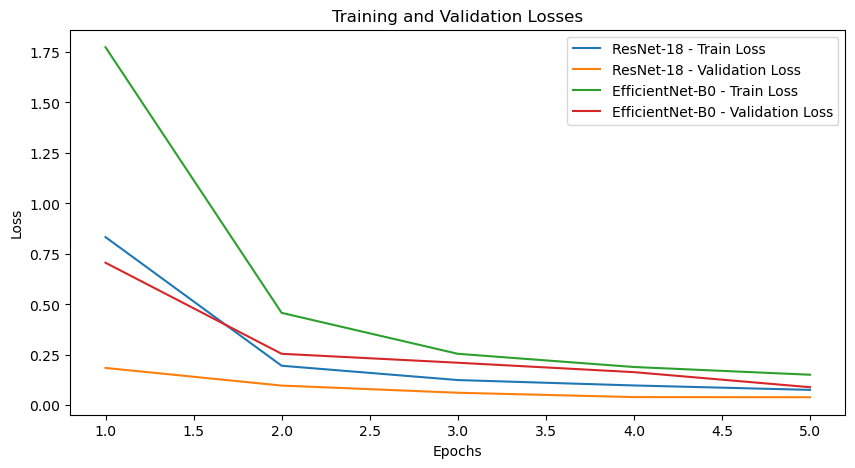

c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\romai\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weight


Evaluating model: ResNet-18

ResNet-18 - Test Accuracy: 98.93%, Test Loss: 0.0404

Evaluating model: EfficientNet-B0

EfficientNet-B0 - Test Accuracy: 97.62%, Test Loss: 0.0900

Confusion Matrix for ResNet-18:
Confusion matrix, without normalization


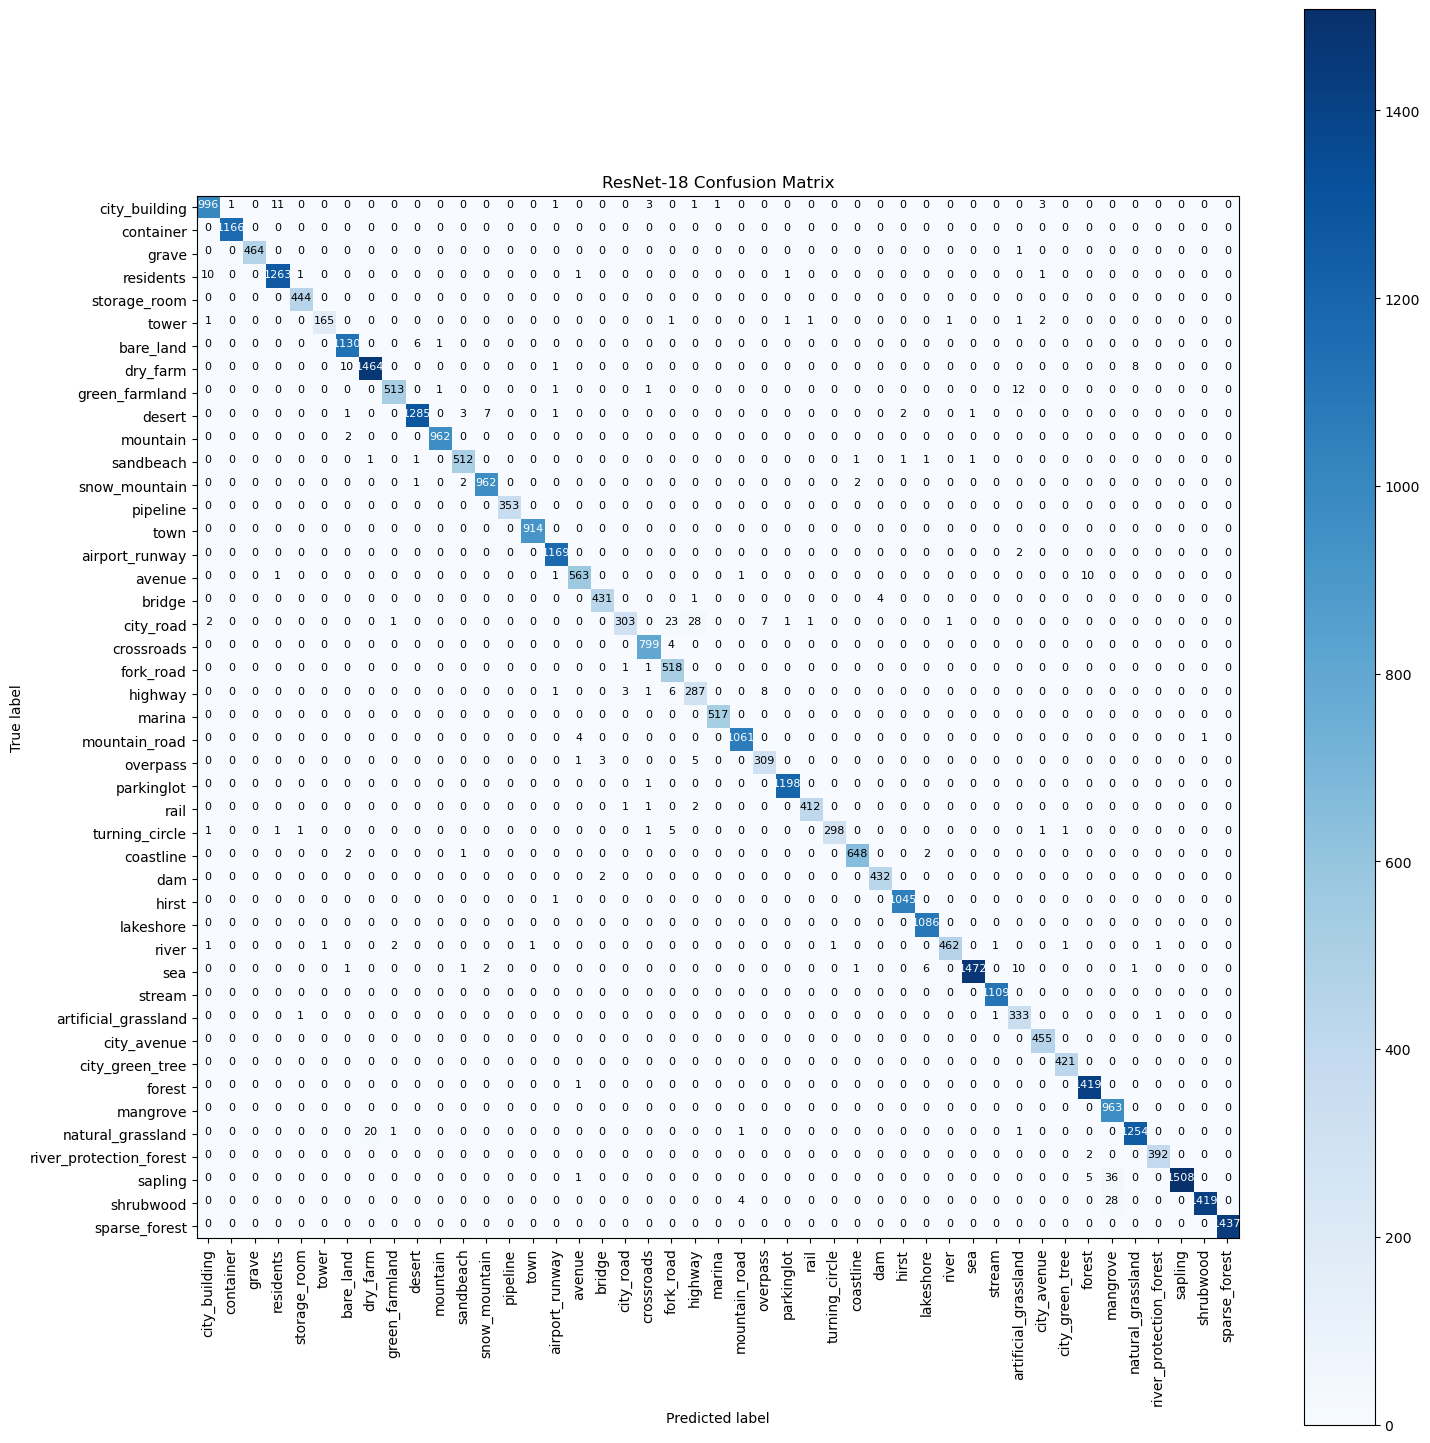


Confusion Matrix for EfficientNet-B0:
Confusion matrix, without normalization


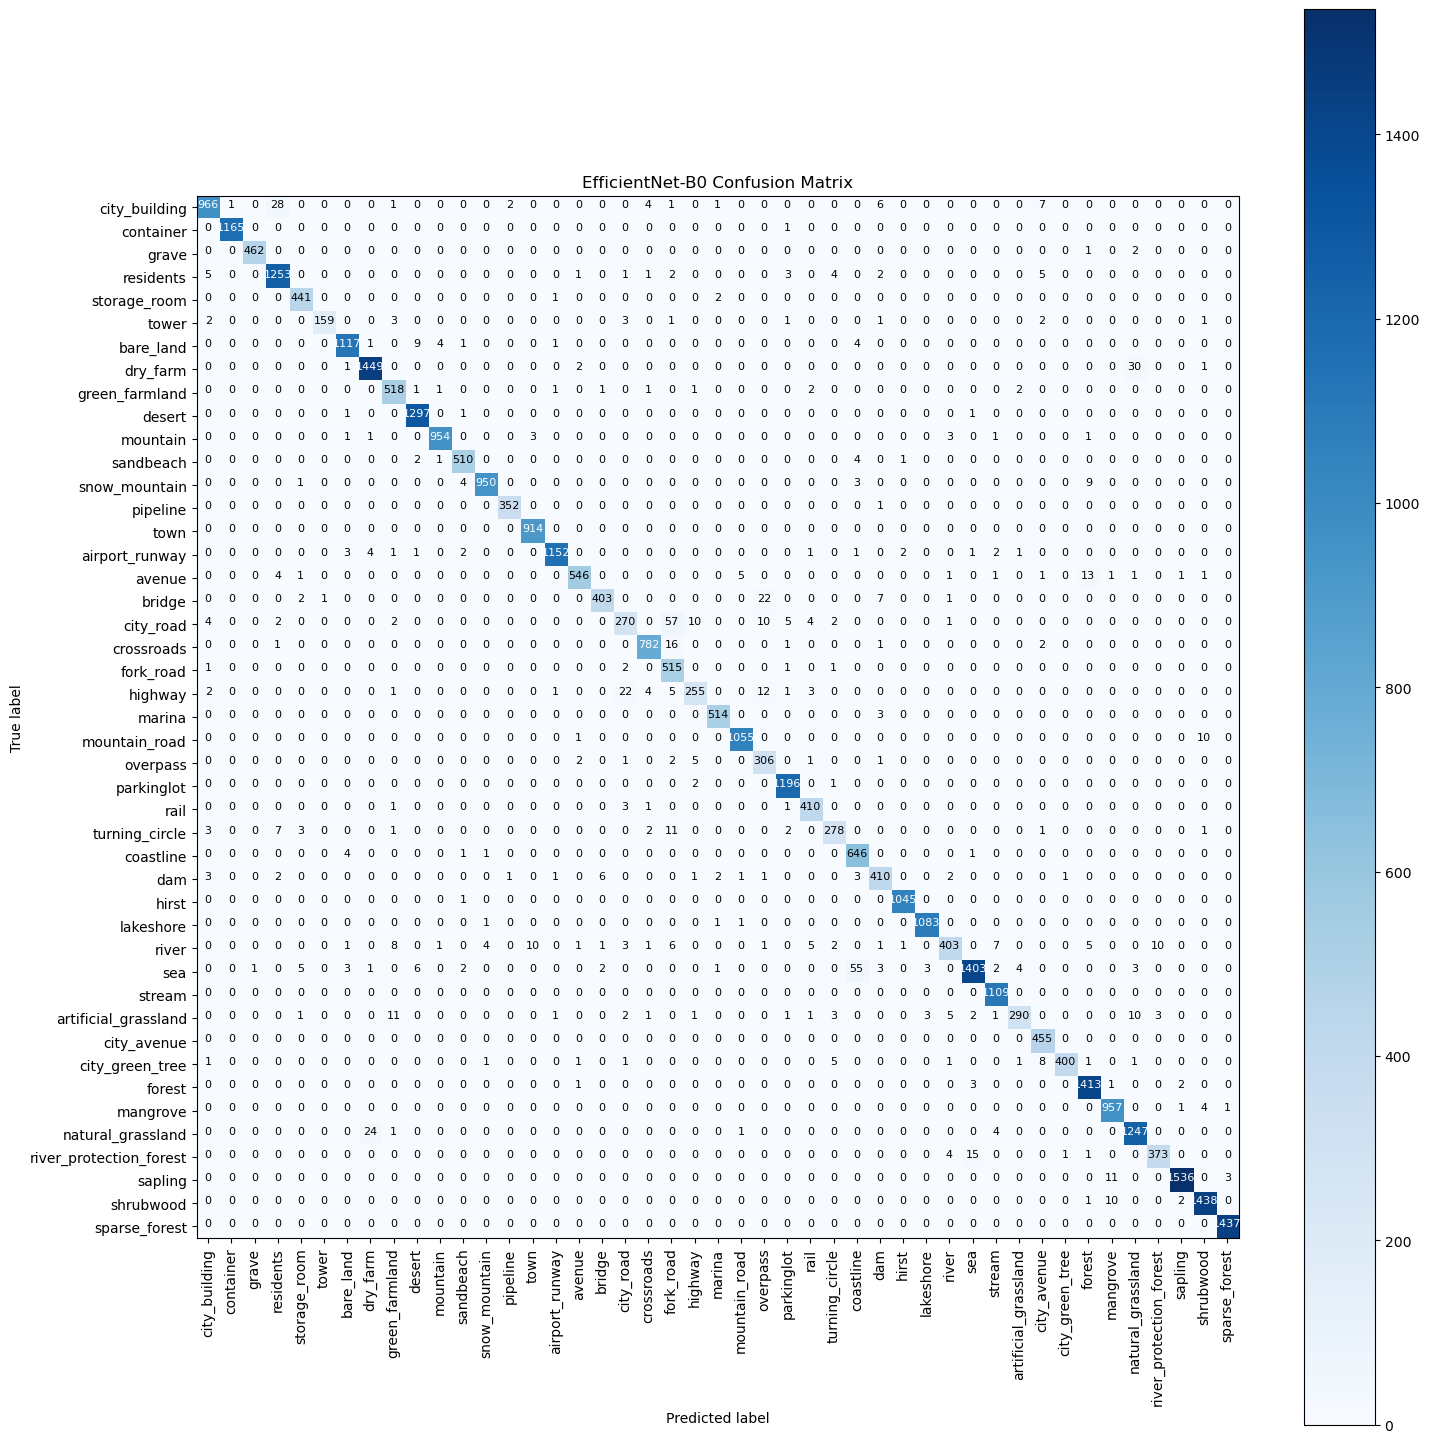

In [13]:
    # Plot training and validation losses for both models
    def plot_losses(results):
        plt.figure(figsize=(10, 5))
        for model_name, result in results.items():
            epochs = range(1, len(result["train_losses"]) + 1)
            plt.plot(epochs, result["train_losses"], label=f"{model_name} - Train Loss")
            plt.plot(epochs, result["val_losses"], label=f"{model_name} - Validation Loss")
        plt.title("Training and Validation Losses")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    plot_losses(results)

        #Evaluate the model
    def evaluate_model(model, test_loader):
        model.eval()  #Set the model to evaluation mode, which disables dropout and batch normalization
        model.to(device)
        val_loss = 0  #Initialize validation loss
        correct = 0  #Count of correct predictions
        total = 0  #Total number of examples processed
        all_preds = []  #List to store all predictions
        all_labels = []  #List to store all true labels

        with torch.no_grad():  #Disable gradient computation to speed up the process and reduce memory usage
            for images, labels in test_loader:  #Iterate over all batches in the test dataset
                images, labels = images.to(device), labels.to(device)  #Move images and labels to the specified device
                outputs = model(images)  #Compute the model's output
                loss = criterion(outputs, labels)  #Calculate the loss based on the criterion
                val_loss += loss.item()  #Accumulate the loss

                _, predicted = torch.max(outputs.data, 1)  #Get the predicted classes (highest output values)
                total += labels.size(0)  #Update total count of examples
                correct += (predicted == labels).sum().item()  #Update correct count based on how many predictions match the labels

                all_preds.extend(predicted.cpu().numpy())  #Store predictions in a list
                all_labels.extend(labels.cpu().numpy())  #Store true labels in a list

        avg_val_loss = val_loss / len(test_loader)  #Calculate average validation loss
        avg_accuracy = correct / total  #Calculate accuracy as the ratio of correct predictions to total examples

        return avg_val_loss, avg_accuracy, all_preds, all_labels  #Return the computed metrics and lists of predictions and labels


    #Import model
    model1 = resnet18(pretrained=False) 
    #Adapt it to the number of classes on the last layer
    num_features = model1.fc.in_features
    model1.fc = nn.Linear(num_features, 45) 
    #Load the model saved
    state_dict = torch.load('resnet_18.pth')
    model1.load_state_dict(state_dict)

        #Import model
    model2 = efficientnet_b0(pretrained=False) 
    #Adapt it to the number of classes on the last layer
    num_features = model2.classifier[1].in_features  # Get the number of input features for the classifier
    model2.classifier[1] = nn.Linear(num_features, 45)  # Replace the final layer with 45 output classes
    #Load the model saved
    state_dict = torch.load('efficientnet_b0.pth')
    model2.load_state_dict(state_dict)

    # Evaluate both models
    for model_name, model in {"ResNet-18": model1, "EfficientNet-B0": model2}.items():
        print(f"\nEvaluating model: {model_name}\n")
        test_loss, test_accuracy, all_preds, all_labels = evaluate_model(model, test_loader)
        results[model_name].update({
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "all_preds": all_preds,
            "all_labels": all_labels
        })
        print(f"{model_name} - Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")

    """
    ----------------------------- Création et affichage de la matrice de confusion ----------------------------
    """


        # Function to plot the confusion matrix
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
        # Normalize the confusion matrix if specified
        cm = np.array(cm)  # Ensure cm is a numpy array
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Print whether the confusion matrix is normalized
        print("Confusion matrix, without normalization" if not normalize else "Normalized confusion matrix")

        # Plot the confusion matrix
        plt.figure(figsize=(15, 15))  # Adjust figure size for better readability
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        # Format the values in the confusion matrix
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=8,  # Adjust font size
                    color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


    # Generate and display confusion matrices
    for model_name, result in results.items():
        print(f"\nConfusion Matrix for {model_name}:")
        cm = confusion_matrix(result["all_labels"], result["all_preds"])
        plot_confusion_matrix(cm, train_dataset.classes, title=f"{model_name} Confusion Matrix")
        #plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')




Displaying predictions for ResNet-18:



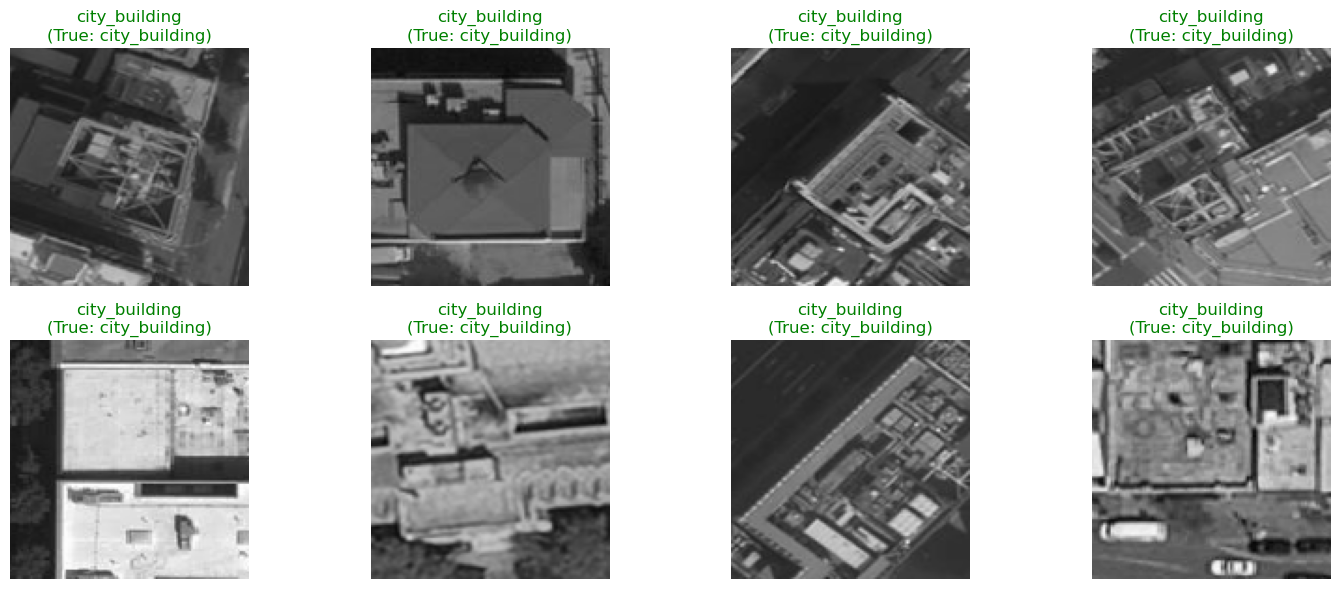


Displaying predictions for EfficientNet-B0:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3712048524405773e-08..0.9333334145069122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843121099472064..1.0000000558137894].


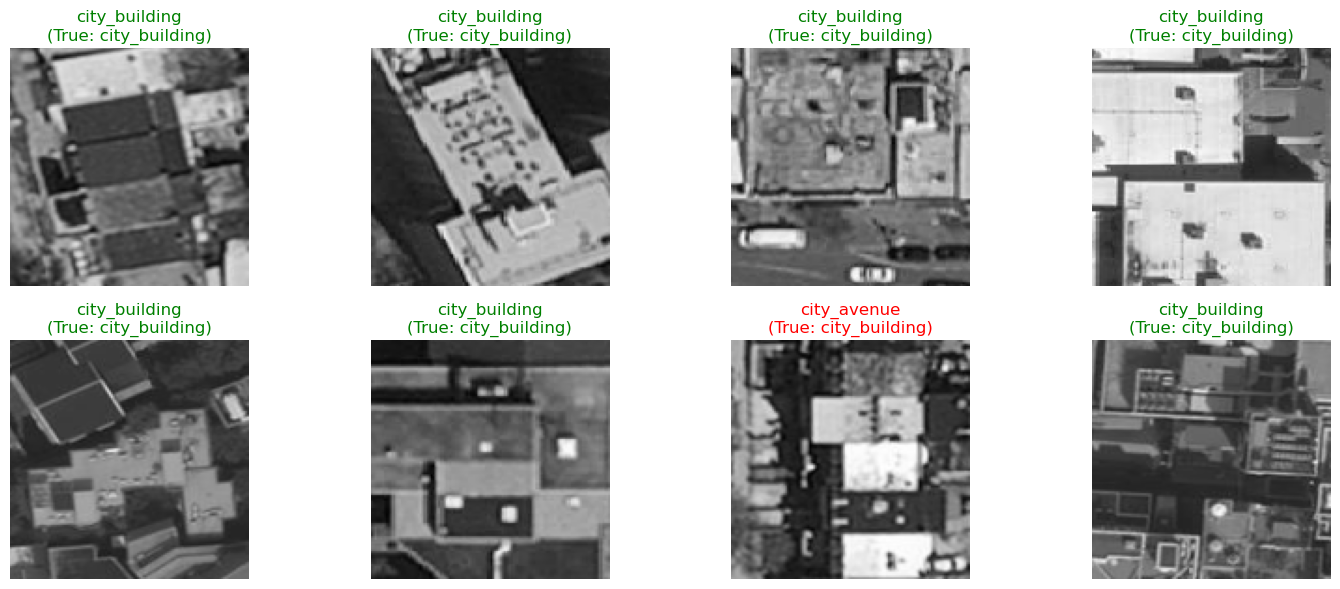

In [14]:

    """
    ==========================================================================================================
    ==========================================================================================================
                                 PARTIE 3 - PREDICTION ET AFFICHAGE DES IMAGES   
    ==========================================================================================================
    ==========================================================================================================
    """




    def predict_and_display(model, data_loader, class_names, device='cuda', num_images=8):
        """
        Predict and display a random subset of images with their predicted and true labels.
        """
        model.eval()  # Set the model to evaluation mode
        model.to(device)
        
        with torch.no_grad():  # Turn off gradients to speed up this part
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predictions = torch.max(outputs, 1)
                
                # Randomize the indices of the images
                indices = np.random.choice(len(images), num_images, replace=False)
                #indices = torch.randperm(len(images))[:num_images]  # Select `num_images` random indices

                # Normalize mean and std used for your data
                mean = np.array([0.1307, 0.1307, 0.1307])
                std = np.array([0.3081, 0.3081, 0.3081])
                
                # Plot the images in the batch, along with predicted and true labels
                fig, axes = plt.subplots(2, 4, figsize=(15, 6))  # 2 rows, 4 columns for 8 images
                axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration
                for idx, img_idx in enumerate(indices):
                    image = images[img_idx].cpu().numpy().transpose((1, 2, 0))  # Convert to (H, W, C)
                    image = (image * std) + mean  # Unnormalize if necessary
                    ax = axes[idx]
                    ax.imshow(image, cmap='gray')
                    ax.set_title(f"{class_names[predictions[img_idx]]}\n(True: {class_names[labels[img_idx]]})", 
                                color=("green" if predictions[img_idx] == labels[img_idx] else "red"))
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
                
                # Break after displaying the first batch's selected images
                break


    # Display 8 random predictions for each model
    for model_name, model in {"ResNet-18": model1, "EfficientNet-B0": model2}.items():
        print(f"\nDisplaying predictions for {model_name}:\n")
        predict_and_display(model, test_loader, train_dataset.classes, device=device, num_images=8)